# Start sailing --- the simplest plain CNN model

### The conv-block looks like: (params maybe different)

<div align="center">
  <img src="images/version1/conv-block.png" height="240" width="740"/>           
</div>

### The whole-model looks like:
<div align="center">
  <img src="images/version1/model.png" height="180" width="800" />           
</div>

### The whole parameters:

<div align="center">
  <img src="images/version1/model-params.png" height="410" width="810" />      
</div>

#    
# ---------------------------------------- Start from here!  ---------------------------------------------
#   

## 1. import numpy and helper functions
* **h5py** : The h5py package is a Pythonic interface to the HDF5 binary data format.
* **matplotlib** : Matplotlib is a Python 2D plotting library.

In [1]:
import h5py
import numpy as np
from helper_v1 import *
import matplotlib.pyplot as plt

## 2. build blocks for structuring model

* **CONV_BLOCK_F** : conv -> pool -> relu in the **forward** step.

* **CONV_BLOCK_B** : relu -> pool -> conv in the **backward** step.

* **NN_BLOCK_F** : nn -> relu or sigmoid in the **forward** step.

* **NN_BLOCK_B** : relu or sigmoid -> nn in the **backward** step.

In [2]:
def CONV_BLOCK_F(X, W, b, params):
    
    # conv_f -> pool_f -> reLu
    # X : (m, n_H, n_W, n_C)
    # W : (filters, f, f, n_C)
    # b : (filters,)
    # params : dict { 'conv_s', 'conv_pad', 'pool_s', 'pool_f', 'mode' }
    
    mode = params['mode']
    pool_param = {'s':params['pool_s'], 'f':params['pool_f']}
    conv_param = {'s':params['conv_s'], 'pad':params['conv_pad']}
    
    Z1, conv_cache = conv_f(X, W, b, conv_param)
    Z2, pool_cache = pool_f(Z1, pool_param, mode)
    A3 = relu(Z2)
    
    cache = {'conv_cache':conv_cache, 'pool_cache':pool_cache, 'relu_cache':Z2}
    
    return A3, cache

In [3]:
def NN_BLOCK_F(X, W, b, activation):
    
    # nn_f -> activation
    
    Z, nn_cache = nn_f(X, W, b)
    A = relu(Z) if activation=='relu' else sigmoid(Z)
    
    cache = {'nn_cache':nn_cache, 'activation_cache':Z}
    
    return A, cache
    

In [4]:
def CONV_BLOCK_B(dA, cache):
    
    # conv_b <- pool_b <- relu
    # cache : conv & pool & relu cache
    
    relu_Z = cache['relu_cache']
    dZ2 = relu_b(dA, relu_Z)
    
    pool_cache = cache['pool_cache']
    dZ1 = pool_b(dZ2, pool_cache)
    
    conv_cache = cache['conv_cache']
    dX, dW, db = conv_b(dZ1, conv_cache)
    
    grad = {'dW':dW, 'db':db}
    
    return dX, grad


In [5]:
def NN_BLOCK_B(dA, cache, activation):
    
    # nn_f <- activation
    
    active_Z = cache['activation_cache']
    active_back = relu_b if activation=='relu' else sigmoid_b
    dZ = active_back(dA, active_Z)
    
    nn_cache = cache['nn_cache']
    dX, dW, db = nn_b(dZ, nn_cache)
    
    grad = {'dW':dW, 'db':db}
    
    return dX, grad
    

## 3. Build the whold forward and backward steps with blocks that built before.

* **forward** : X -> [model] -> Y_hat, caches
* **backward**: Y_hat, caches -> [model] -> grads

In [6]:
def forward(X, W, b, hparams, caches):
    
    # CONV_BLOCK_F: 1, 2, 3, 4,
    for i in range(1,5):
        X, cache = CONV_BLOCK_F(X, W['unit'+str(i)], b['unit'+str(i)], hparams['unit'+str(i)])
        caches['unit'+str(i)] = cache
    
    # FLATTEN
    X = X.reshape(X.shape[0], 320)
    
    # NN_BLOCK_F: 5, 6, 7, (relu)
    for i in range(5, 8):
        X, cache = NN_BLOCK_F(X, W['unit'+str(i)], b['unit'+str(i)], 'relu')
        caches['unit'+str(i)] = cache
        
    # NN_BLOCK_F: 8 (sigmoid)
    Y_hat, cache = NN_BLOCK_F(X, W['unit8'], b['unit8'], 'sigmoid')
    caches['unit8'] = cache
    
    return Y_hat
    

In [7]:
def backward(dA, caches, grads):
    
    # NOTE THAT: caches, grads are dicts (reference parameters)
    
    # NN_BLOCK_B: 8, (sigmoid)
    dA, grad = NN_BLOCK_B(dA, caches['unit8'], 'sigmoid')
    grads['unit8'] = grad
    
    # NN_BLOCK_B: 7, 6, 5, (relu)
    for i in range(7, 4, -1):
        dA, grad = NN_BLOCK_B(dA, caches['unit'+str(i)], 'relu')
        grads['unit'+str(i)] = grad
    
    # ROLL
    dA = dA.reshape(dA.shape[0], 4, 4, 20)
        
    # CONV_BLOCK_B: 4, 3, 2, 1
    for i in range(4, 0, -1):
        dA, grad = CONV_BLOCK_B(dA, caches['unit'+str(i)])
        grads['unit'+str(i)] = grad
    

## 4. Calculate the cost.

In [19]:
def cross_entropy_cost(Y_hat, Y):
    m = Y.shape[0]
    cost = -np.sum(Y * np.log(Y_hat) + (1-Y) * np.log(1-Y_hat)) / m
    dY_hat = np.divide(1-Y, 1-Y_hat) - np.divide(Y, Y_hat)
    return cost, dY_hat

## 5. Initialize the parameters
* use **he** intialization

In [9]:
def initialization():
    
    W = {}
    b = {}
    hparams = {}
    
    # CONV : 1, 2, 3, 4
    b['unit1'] = np.zeros((8,), dtype=np.float32)
    W['unit1'] = np.random.randn(8,3,3,3).astype(np.float32)*np.sqrt(2./(32*32*3+28*28*8))
    hparams['unit1'] = {'conv_s': 1, 'conv_pad': 0, 'pool_s': 1, 'pool_f': 3, 'mode': 1}
    
    b['unit2'] = np.zeros((12,), dtype=np.float32)
    W['unit2'] = np.random.randn(12,5,5,8).astype(np.float32)*np.sqrt(2./(28*28*8+20*20*12))
    hparams['unit2'] = {'conv_s': 1, 'conv_pad': 0, 'pool_s': 1, 'pool_f': 5, 'mode': 1}
    
    b['unit3'] = np.zeros((16,), dtype=np.float32)
    W['unit3'] = np.random.randn(16,5,5,12).astype(np.float32)*np.sqrt(2./(20*20*12+12*12*16))
    hparams['unit3'] = {'conv_s': 1, 'conv_pad': 0, 'pool_s': 1, 'pool_f': 5, 'mode': 1}
    
    b['unit4'] = np.zeros((20,), dtype=np.float32)
    W['unit4'] = np.random.randn(20,5,5,16).astype(np.float32)*np.sqrt(2./(12*12*6+4*4*20))
    hparams['unit4'] = {'conv_s': 1, 'conv_pad': 0, 'pool_s': 1, 'pool_f': 5, 'mode': 1}
    
    # NN : 5, 6, 7, 8
    b['unit5'] = np.zeros((128,), dtype=np.float32)
    W['unit5'] = np.random.randn(128, 320).astype(np.float32)*np.sqrt(2./(128+320))

    b['unit6'] = np.zeros((64,), dtype=np.float32)
    W['unit6'] = np.random.randn(64, 128).astype(np.float32)*np.sqrt(2./(64+128))
    
    b['unit7'] = np.zeros((32,), dtype=np.float32)
    W['unit7'] = np.random.randn(32, 64).astype(np.float32)*np.sqrt(2./(32+64))
    
    b['unit8'] = np.zeros((1,), dtype=np.float32)
    W['unit8'] = np.random.randn(1, 32).astype(np.float32)*np.sqrt(2./(1+32))
    
    return W, b, hparams
    

## 6. Build optimization function. Now I just use gradient descent.

In [10]:
def update_params(W, b, grads, lr):
    for i in range(1,9):
        W['unit'+str(i)] -= lr*grads['unit'+str(i)]['dW']
        b['unit'+str(i)] -= lr*grads['unit'+str(i)]['db']

## 7. Now, build the whole model.

In [20]:
def model(X_train, Y_train, batch=32, epochs=2, lr=0.008, params=None, use_trained_params=False):
    
    # X : (m, 32, 32, 3)
    # Y : (m, 1)
    # batch : default 32
    # epochs : the number of iteration
    # lr : learning_rate, default 0.008
    # dicts: grads, caches, W, b, hparams

    costs = []
    grads = {}
    caches = {}
    
    m = Y_train.shape[0]
    loops = m // batch
    
    W, b, hparams = params if use_trained_params else initialization()
    
    for i in range(epochs):
        
        for l in range(loops):
            
            start, end = l*batch, (l+1)*batch
            ## forward -> cost -> backward -> update
            Y_hat = forward(X_train[start:end], W, b, hparams, caches)
            cost, dY_hat = cross_entropy_cost(Y_hat, Y_train[start:end])
            backward(dY_hat, caches, grads)
            update_params(W, b, grads, lr)
            
            costs.append(cost)
            
            if (l % 10 == 0):
                print('No.' + str(l) + '\t coat is --------->  ' + str(cost))
        
        # check the remainder
        remainder = m % batch
        if remainder != 0:
            start = -remainder
            ## forward -> cost -> backward -> update
            Y_hat = forward(X_train[start:], W, b, hparams, caches)
            cost, dY_hat = cross_entropy_cost(Y_hat, Y_train[start:])
            backward(dY_hat, caches, grads)
            update_params(W, b, grads, lr)
            
            costs.append(cost)
    
    # Everything is done!
    
    return costs, W, b, hparams
    

## 8. Prepare the data
* train: **3200** imgs
* test : **400**  imgs
* image shape: **(32, 32, 3)**

In [12]:
# open file
f = h5py.File('datasets/car-v1.h5', 'r', driver='core')
# train data
X_train = f['X'][:3200]
Y_train = f['Y'][:3200]
# test data
X_test = f['X'][3200:]
Y_test = f['Y'][3200:]
# close
f.close()

In [14]:
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

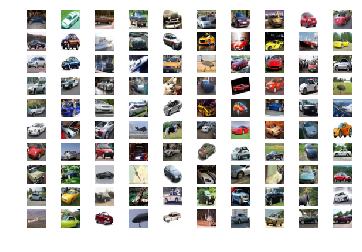

In [16]:
AMOUNT = 10
imgs = X_train[:100]
fig, axes = plt.subplots(AMOUNT, AMOUNT)
c = 0
for i in range(AMOUNT):
    for j in range(AMOUNT):
        axes[i,j].imshow(imgs[c])
        axes[i,j].axis('off')
        c += 1
plt.show()

## 9. Now, start to train the model

# First epoch : (lr = 0.05)

In [32]:
costs, W, b, hparams = model(X_train, Y_train, batch=32, epochs=1, lr=0.05)

No.0	 coat is --------->  0.678222894669
No.10	 coat is --------->  0.556332588196
No.20	 coat is --------->  0.532469987869
No.30	 coat is --------->  0.408649563789
No.40	 coat is --------->  0.501366615295
No.50	 coat is --------->  0.488589584827
No.60	 coat is --------->  0.37946292758
No.70	 coat is --------->  0.455402314663
No.80	 coat is --------->  0.506862282753
No.90	 coat is --------->  0.57527089119


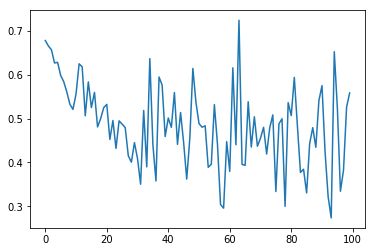

In [33]:
plt.plot(range(len(costs)), costs)
plt.show()

## shuffte

In [34]:
idx = np.arange(3200)
np.random.shuffle(idx)

# Second iteration : (lr = 0.04)

In [35]:
costs, W, b, hparams = model(X_train[idx], Y_train[idx], batch=32, epochs=1, lr=0.04, params=(W, b, hparams), use_trained_params=True)

No.0	 coat is --------->  0.294484615326
No.10	 coat is --------->  0.358254134655
No.20	 coat is --------->  0.486423134804
No.30	 coat is --------->  0.479158103466
No.40	 coat is --------->  0.580856025219
No.50	 coat is --------->  0.34568965435
No.60	 coat is --------->  0.383377432823
No.70	 coat is --------->  0.644888281822
No.80	 coat is --------->  0.42276969552
No.90	 coat is --------->  0.424322783947


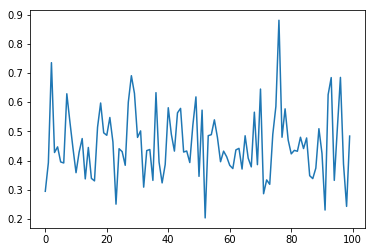

In [36]:
plt.plot(range(len(costs)), costs)
plt.show()

In [37]:
np.random.shuffle(idx)

# Third iteration: (lr = 0.04)

In [38]:
costs, W, b, hparams = model(X_train[idx], Y_train[idx], batch=32, epochs=1, lr=0.04, params=(W, b, hparams), use_trained_params=True)

No.0	 coat is --------->  0.520582795143
No.10	 coat is --------->  0.435734629631
No.20	 coat is --------->  0.477818727493
No.30	 coat is --------->  0.461176037788
No.40	 coat is --------->  0.380928516388
No.50	 coat is --------->  0.447139143944
No.60	 coat is --------->  0.351373255253
No.70	 coat is --------->  0.44099214673
No.80	 coat is --------->  0.432422101498
No.90	 coat is --------->  0.377891361713


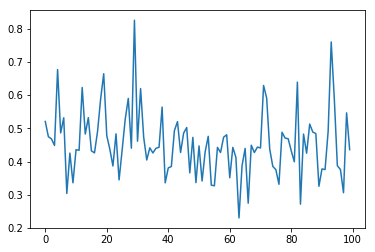

In [39]:
plt.plot(range(len(costs)), costs)
plt.show()

In [40]:
np.random.shuffle(idx)

# Fourth iteration: (lr = 0.03)

In [41]:
costs, W, b, hparams = model(X_train[idx], Y_train[idx], batch=32, epochs=1, lr=0.03, params=(W, b, hparams), use_trained_params=True)

No.0	 coat is --------->  0.37611785531
No.10	 coat is --------->  0.441958099604
No.20	 coat is --------->  0.538318276405
No.30	 coat is --------->  0.524510860443
No.40	 coat is --------->  0.493931889534
No.50	 coat is --------->  0.475022792816
No.60	 coat is --------->  0.47081425786
No.70	 coat is --------->  0.574412703514
No.80	 coat is --------->  0.37761759758
No.90	 coat is --------->  0.224405348301


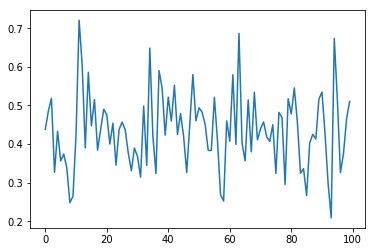

In [29]:
plt.plot(range(len(costs)), costs)
plt.show()

In [42]:
np.random.shuffle(idx)

# Fifth iteration: (lr = 0.03)

In [43]:
costs, W, b, hparams = model(X_train[idx], Y_train[idx], batch=32, epochs=1, lr=0.03, params=(W, b, hparams), use_trained_params=True)

No.0	 coat is --------->  0.424308896065
No.10	 coat is --------->  0.747703313828
No.20	 coat is --------->  0.344196468592
No.30	 coat is --------->  0.570934772491
No.40	 coat is --------->  0.474974989891
No.50	 coat is --------->  0.488757073879
No.60	 coat is --------->  0.331090331078
No.70	 coat is --------->  0.604184627533
No.80	 coat is --------->  0.481318682432
No.90	 coat is --------->  0.449478209019


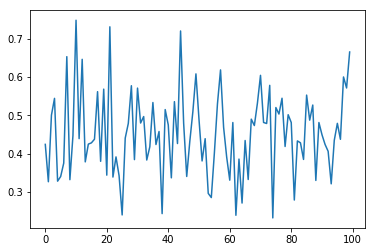

In [44]:
plt.plot(range(len(costs)), costs)
plt.show()

# Summarize

* model : Plain model.
* activation : Relu used in the middle layers and sigmoid used in the output layer.
* initialization : he (Make sure the Var(X)=Var(Y) to prevent the vanishing and exploding problem as far as possible)
* normalization: Has'n used yet.
* optimization: Just gradient descent with fixed α (learning rate).

# Next version:
* I will use normalization and advanced optimization methods, simultaneously I will use just little smaller datasets.